# Motor Control Bench Test Procedure

This notebook describes a procedure that exercises the following functionality:

1. Tachometers.
2. Arm/disarm and manual motor control.
3. Speed measurement.
4. PID motor control.

In [1]:
%load_ext autoreload
%autoreload 2

## Vehicle part identification and orientation conventions

![img](./Assets/RoverInTestBenchTopView.jpeg)

### Connection to vehicle and health check

Find which port is the vehicle connected to.
In linux, usually it is:

- **Development mode (STM32 UART3 / USB)**: ttyACM0, ttyACM1, ...
- **Production mode (STM32 UART 1)**: ttyUSB0, ttyUSB1, ...

Development/production mode must match the UartTcTmHandle parameter chosen when building firmware:

~~~c++
/* USER CODE END Header_DefaultTaskMain */
void DefaultTaskMain(void *argument)
{
  /* USER CODE BEGIN 5 */
	Config.UartTcTmHandle = &huart3; // Development mode
	//Config.UartTcTmHandle = &huart1; // Production mode
    
    /* ... */
    
	ApplicationMain(&Config);
  /* USER CODE END 5 */
}
~~~

In [2]:
!ls /dev/ttyUSB*

ls: cannot access '/dev/ttyUSB*': No such file or directory


In [3]:
!ls /dev/ttyACM*

/dev/ttyACM0


In [4]:
import sys
sys.path.append("../")
from rover.vehicleif import VehicleIF

#VEHICLE_UART_TCTM_PORT = "/dev/ttyUSB1" # Production mode
VEHICLE_UART_TCTM_PORT = "/dev/ttyACM0" # Development mode

connection_params = {
    "mode": VehicleIF.MODE_DIRECT_SERIAL,
    "port": VEHICLE_UART_TCTM_PORT,
    "baudrate": 115200
}

vehicle = VehicleIF(connection_params,debug=False)
vehicle.capture_path = "./captures"

For a quick health check, see current telemetry state:

In [5]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 240
   OnBoardTime: 144380
   ReceivedPackets: 2
   GeneralStatus: 0x01000000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 239
   OnBoardTime: 143880
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 21
   Tachometer3: 11
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
No IMU telemetry frames have been received yet.


For a quick command test, turn on and off led.

In [6]:
# Led on
vehicle.control_led(0x00000001)

Sent: 0x 40 3C 05 00 00 00 00 01 A2 0A  (10 bytes)


In [7]:
# Led off
vehicle.control_led(0x00000000)

Sent: 0x 40 3C 05 00 00 00 00 00 93 0A  (10 bytes)


## Procedure

### 1. Tachometer readings

**Preconditions**

- Reset the vehicle to ensure all tachometer readings are at zero.

In [9]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 4
   OnBoardTime: 0
   ReceivedPackets: 0
   GeneralStatus: 0x00000000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 4
   OnBoardTime: 0
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 0
   Tachometer3: 0
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
No IMU telemetry frames have been received yet.


Start logging telemetry.

In [10]:
vehicle.start_telemetry_csv_logging()

In [11]:
input("Move wheels and press any key when done")

Move wheels and press any key when done 


''

- Move wheel 1.
- Move wheel 2.
- Move wheel 3.
- Move wheel 4.

Stop logging telemetry.

In [12]:
vehicle.stop_telemetry_csv_logging()

In [13]:
!ls {vehicle.capture_path}

tctm.telemetry.GeneralTelemetry.csv  tctm.telemetry.MotorControlTelemetry.csv
tctm.telemetry.IMUTelemetry.csv


In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df.head(5)

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags
0,13,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,14,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,15,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,16,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,17,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


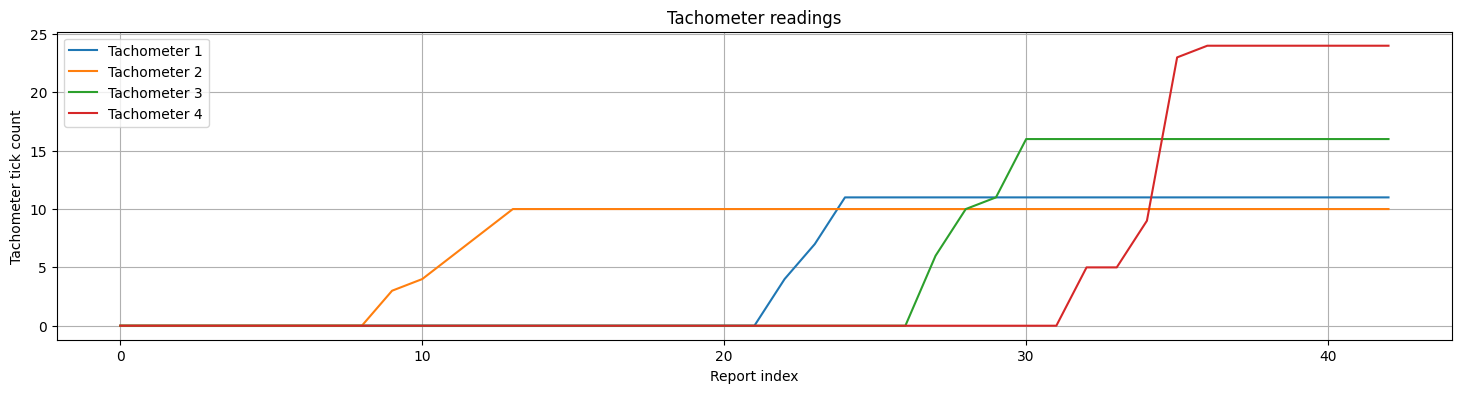

In [15]:
fig, axes = plt.subplots(1,1,figsize=(18,4))
axes.plot(motor_control_tm_df.Tachometer1)
axes.plot(motor_control_tm_df.Tachometer2)
axes.plot(motor_control_tm_df.Tachometer3)
axes.plot(motor_control_tm_df.Tachometer4)
axes.grid(which="Both")
axes.set_xlabel("Report index")
axes.set_ylabel("Tachometer tick count")
axes.legend(["Tachometer 1","Tachometer 2","Tachometer 3","Tachometer 4"])
axes.set_title("Tachometer readings");

### 2. Manual motor control

In [16]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 71
   OnBoardTime: 0
   ReceivedPackets: 0
   GeneralStatus: 0x00000000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 71
   OnBoardTime: 0
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 11
   Tachometer2: 10
   Tachometer3: 16
   Tachometer4: 24
   MeasuredSpeed1: inf
   MeasuredSpeed2: 5.909217834472656
   MeasuredSpeed3: inf
   MeasuredSpeed4: inf
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
No IMU telemetry frames have been received yet.


Attempt to start motor when disarmed (should fail).

In [17]:
vehicle.set_motor_throttles(0.5,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 3F 00 00 00 00 00 00 00 CC 0A  (18 bytes)


In [18]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 126
   OnBoardTime: 75880
   ReceivedPackets: 1
   GeneralStatus: 0x00010000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 126
   OnBoardTime: 76130
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 11
   Tachometer2: 10
   Tachometer3: 16
   Tachometer4: 24
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
No IMU telemetry frames have been received yet.


Arm in manual mode.

In [19]:
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_ARM_MANUAL)

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)


In [20]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 155
   OnBoardTime: 93380
   ReceivedPackets: 2
   GeneralStatus: 0x01030001
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 155
   OnBoardTime: 93505
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 11
   Tachometer2: 10
   Tachometer3: 16
   Tachometer4: 24
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000001
IMU Telemetry
No IMU telemetry frames have been received yet.


Check vehicle right side moves forward.

In [21]:
vehicle.set_motor_throttles(0.5,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 3F 00 00 00 00 00 00 00 CC 0A  (18 bytes)


Check vehicle right side moves backward.

In [22]:
vehicle.set_motor_throttles(-0.4,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 BE CC CC CD 00 00 00 00 20 0A  (18 bytes)


Stop.

In [23]:
vehicle.set_motor_throttles(0.0,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 00 00 00 00 00 00 00 00 D4 0A  (18 bytes)


Check vehicle left side moves backward.

In [24]:
vehicle.set_motor_throttles(0.0,0.5,0x2)

Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3F 00 00 00 FC 0A  (18 bytes)


Check vehicle left side moves backward.

In [25]:
vehicle.set_motor_throttles(0.0,-0.5,0x2)

Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 BF 00 00 00 0D 0A  (18 bytes)


Both sides forward.

In [26]:
vehicle.set_motor_throttles(0.5,0.5,0x3)

Sent: 0x 40 3C 0D 01 00 00 00 03 3F 00 00 00 3F 00 00 00 51 0A  (18 bytes)


Both sides backward.

In [27]:
vehicle.set_motor_throttles(-0.5,-0.5,0x3)

Sent: 0x 40 3C 0D 01 00 00 00 03 BF 00 00 00 BF 00 00 00 62 0A  (18 bytes)


Disarm.

In [28]:
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_DISARM)

Sent: 0x 40 3C 05 03 00 00 00 00 D7 0A  (10 bytes)


### 3. Speed measurement

In [29]:
import numpy as np
import time

In [30]:
MIN_ABS_THROTTLE=0.0
MAX_ABS_THROTTLE=1.0
N_SAMPLES = 32
INTERVAL_IN_S = 1.0
SUSTAIN_INTERVAL_IN_S = 5.0

In [31]:
def do_motor_curve(vehicle, min_value, max_value, n_samples, interval, side):
    for throttle in np.linspace(min_value,max_value,n_samples):
        if side == 'left':
            vehicle.set_motor_throttles(throttle,0.0,0x1)
        elif side == 'right':
            vehicle.set_motor_throttles(0.0, throttle, 0x2)
        else:
            vehicle.set_motor_throttles(throttle,throttle,0x3)
        time.sleep(interval)

In [32]:
def perform_motor_test(vehicle, min_abs_throttle, max_abs_throttle, n_samples, interval, sustain_interval, side):
    # Start logging
    vehicle.start_telemetry_csv_logging()

    # Arm 
    vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_ARM_MANUAL)
    time.sleep(0.5)

    # Ramp up
    do_motor_curve(vehicle, min_abs_throttle, max_abs_throttle, n_samples, interval, side)
    # Sustain
    time.sleep(sustain_interval)
    # Ramp down
    do_motor_curve(vehicle, max_abs_throttle, min_abs_throttle, n_samples, interval, side)

    # Disarm
    vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_DISARM)

    # Stop logging
    vehicle.stop_telemetry_csv_logging()

#### 3.1 Left side

In [33]:
SIDE = "left" # left, right, or both
perform_motor_test(vehicle,MIN_ABS_THROTTLE,MAX_ABS_THROTTLE,N_SAMPLES,INTERVAL_IN_S,SUSTAIN_INTERVAL_IN_S,SIDE)

motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df["AverageSpeed12"] = (motor_control_tm_df.MeasuredSpeed1+ motor_control_tm_df.MeasuredSpeed2)/2
motor_control_tm_df.tail()

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 00 00 00 00 00 00 00 00 D4 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3D 04 21 08 00 00 00 00 FB 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3D 84 21 08 00 00 00 00 47 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3D C6 31 8C 00 00 00 00 D3 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 04 21 08 00 00 00 00 20 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 25 29 4A 00 00 00 00 6A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 46 31 8C 00 00 00 00 B4 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 67 39 CE 00 00 00 00 FE 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 84 21 08 00 00 00 00 9C 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 94 A5 29 00 00 00 00 B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E A5 29 4A 00 00 00 00 D6 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E B5 AD 6B 00 00 00 00 F3 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E C6 31 8C 00 0

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed12
112,323,194380,0.064516,0.0,5328,5503,483,454,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
113,324,194880,0.032258,0.0,5328,5503,483,454,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
114,325,195505,0.032258,0.0,5328,5503,483,454,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
115,326,196130,0.000000,0.0,5328,5503,483,454,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
116,327,196755,0.000000,0.0,5328,5503,483,454,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


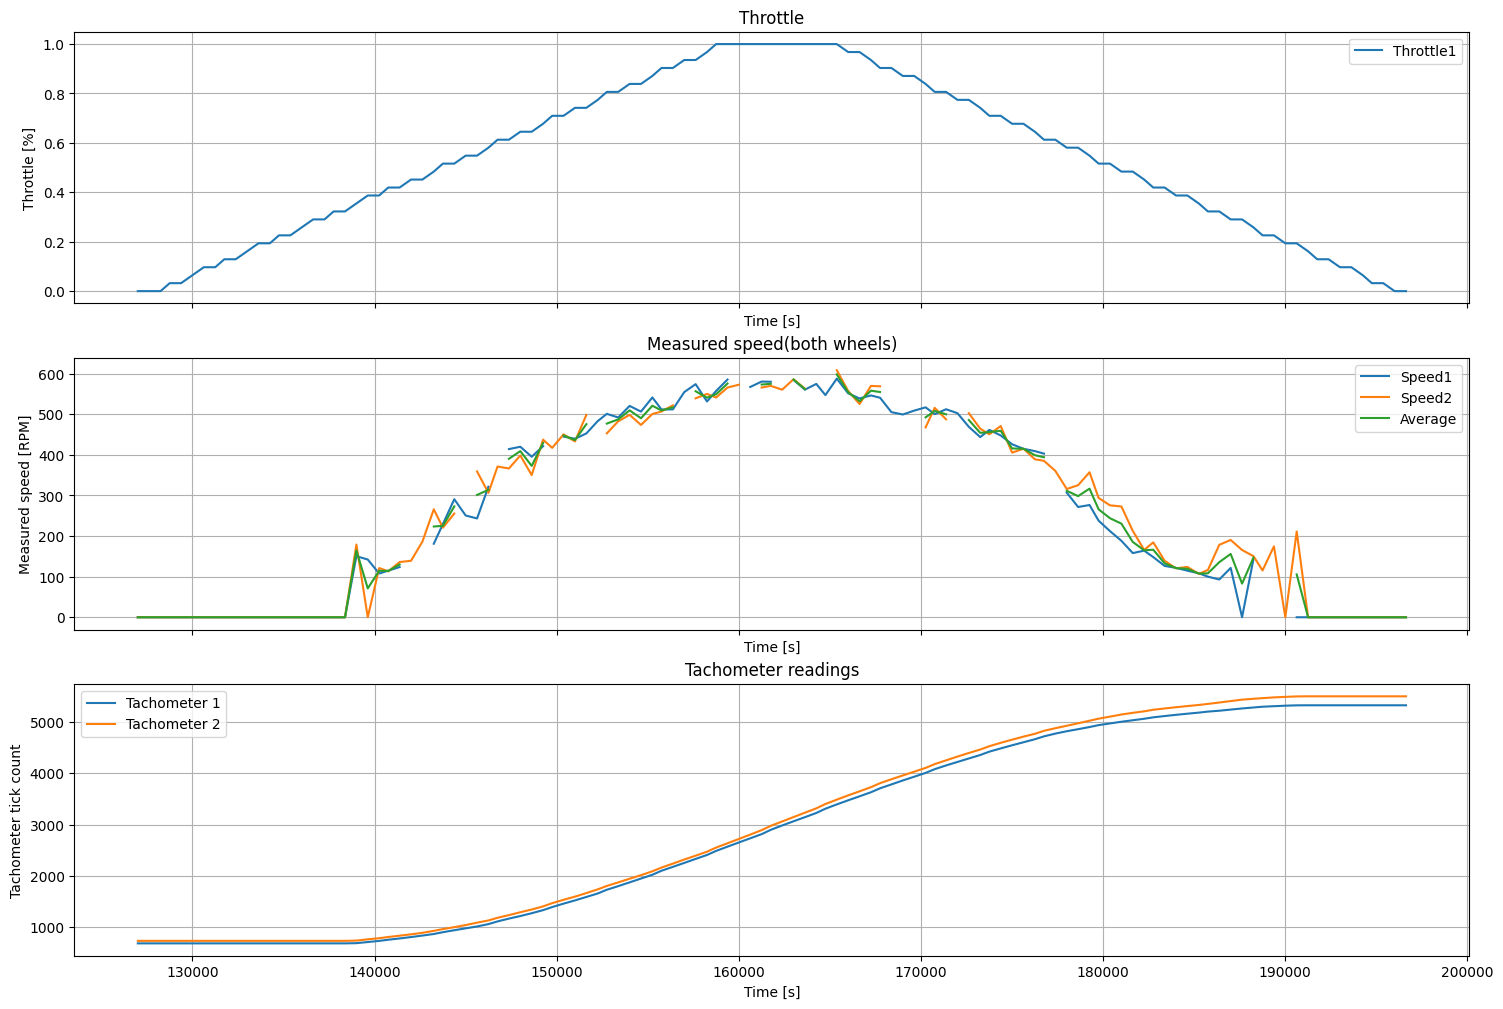

In [34]:
fig, axes = plt.subplots(3,1,figsize=(18,12),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle1)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed1)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed2)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12)
axes[1].set_title("Measured speed(both wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed1","Speed2","Average"])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer1)
axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer2)
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Tachometer tick count")
axes[2].legend(["Tachometer 1","Tachometer 2"])
axes[2].set_title("Tachometer readings");

#### 3.2 Right side

In [35]:
SIDE = "right" # left, right, or both
perform_motor_test(vehicle,MIN_ABS_THROTTLE,MAX_ABS_THROTTLE,N_SAMPLES,INTERVAL_IN_S,SUSTAIN_INTERVAL_IN_S,SIDE)

motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df["AverageSpeed34"] = (motor_control_tm_df.MeasuredSpeed3+ motor_control_tm_df.MeasuredSpeed4)/2
motor_control_tm_df.tail()

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 00 00 00 00 3A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3D 04 21 08 43 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3D 84 21 08 96 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3D C6 31 8C 38 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 04 21 08 DF 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 25 29 4A 88 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 46 31 8C 71 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 67 39 CE 26 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 84 21 08 0A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 94 A5 29 B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E A5 29 4A 5D 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E B5 AD 6B EE 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E C

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed34
112,462,277755,0.0,0.064516,5332,5507,4390,4438,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
113,463,278380,0.0,0.064516,5332,5507,4390,4438,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
114,464,278880,0.0,0.032258,5332,5507,4390,4438,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
115,465,279505,0.0,0.000000,5332,5507,4390,4438,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
116,466,280130,0.0,0.000000,5332,5507,4390,4438,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


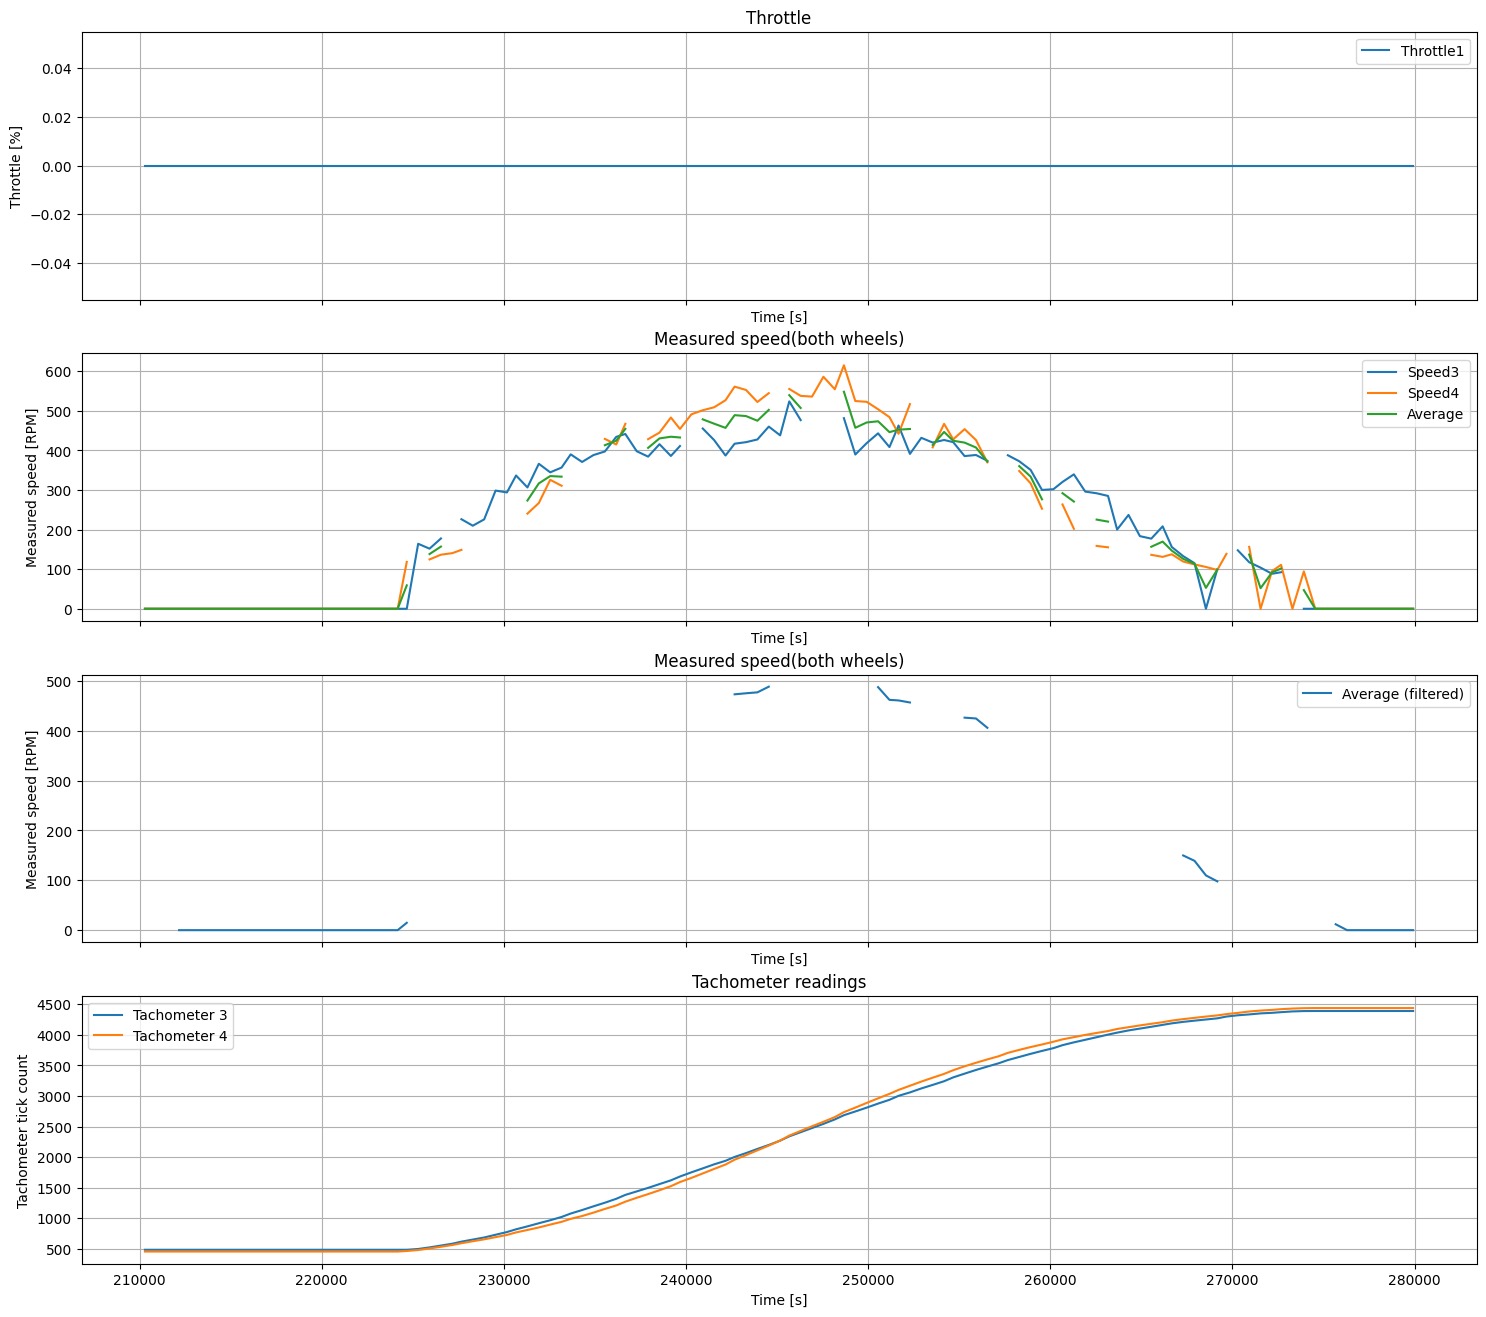

In [36]:
fig, axes = plt.subplots(4,1,figsize=(18,16),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle1)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed3)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed4)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed34)
axes[1].set_title("Measured speed(both wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed3","Speed4","Average"])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed34.rolling(4).mean())
axes[2].set_title("Measured speed(both wheels)")
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Measured speed [RPM]")
axes[2].legend(["Average (filtered)"])

axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer3)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer4)
axes[3].grid(which="Both")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("Tachometer tick count")
axes[3].legend(["Tachometer 3","Tachometer 4"])
axes[3].set_title("Tachometer readings");

#### 3.3 Both sides

In [37]:
SIDE = "both" # left, right, or both
perform_motor_test(vehicle,MIN_ABS_THROTTLE,MAX_ABS_THROTTLE,N_SAMPLES,INTERVAL_IN_S,SUSTAIN_INTERVAL_IN_S,SIDE)

motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df["AverageSpeed12"] = (motor_control_tm_df.MeasuredSpeed1+ motor_control_tm_df.MeasuredSpeed2)/2
motor_control_tm_df["AverageSpeed34"] = (motor_control_tm_df.MeasuredSpeed3+ motor_control_tm_df.MeasuredSpeed4)/2
motor_control_tm_df.tail()

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 00 00 00 00 00 00 00 00 8F 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3D 04 21 08 3D 04 21 08 D9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3D 84 21 08 3D 84 21 08 B0 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3D C6 31 8C 3D C6 31 8C 8A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 04 21 08 3E 04 21 08 9E 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 25 29 4A 3E 25 29 4A 83 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 46 31 8C 3E 46 31 8C A4 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 67 39 CE 3E 67 39 CE B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 84 21 08 3E 84 21 08 F7 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 94 A5 29 3E 94 A5 29 61 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E A5 29 4A 3E A5 29 4A EA 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E B5 AD 6B 3E B5 AD 6B 7C 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E C6 31 8C 3E C

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed12,AverageSpeed34
111,603,362380,0.064516,0.064516,9278,9609,8006,7909,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
112,604,362880,0.064516,0.064516,9278,9609,8006,7909,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
113,605,363505,0.032258,0.032258,9278,9609,8006,7909,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
114,606,364130,0.032258,0.032258,9278,9609,8006,7909,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
115,607,364755,0.000000,0.000000,9278,9609,8006,7909,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0


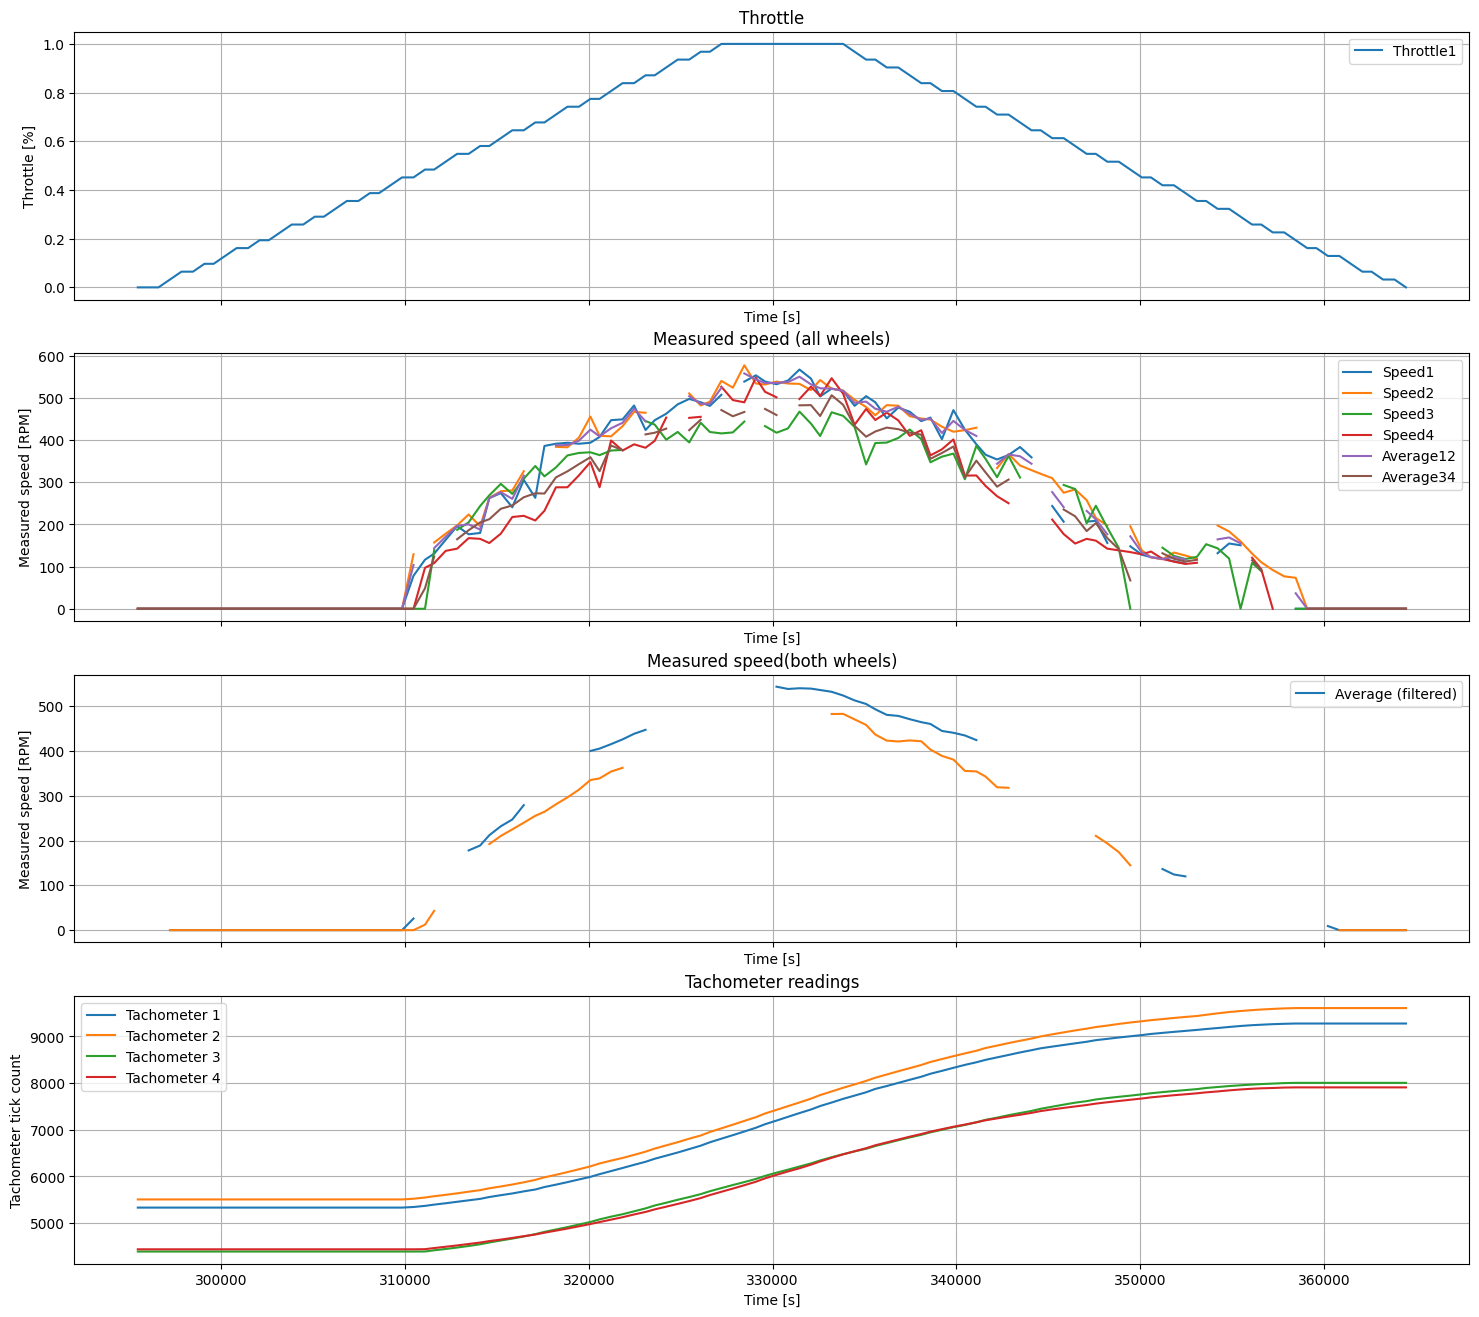

In [38]:
fig, axes = plt.subplots(4,1,figsize=(18,16),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle1)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed1)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed2)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed3)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed4)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed34)
axes[1].set_title("Measured speed (all wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed1","Speed2","Speed3","Speed4","Average12","Average34",])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12.rolling(4).mean())
axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed34.rolling(4).mean())
axes[2].set_title("Measured speed(both wheels)")
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Measured speed [RPM]")
axes[2].legend(["Average (filtered)"])

axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer1)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer2)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer3)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer4)
axes[3].grid(which="Both")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("Tachometer tick count")
axes[3].legend(["Tachometer 1","Tachometer 2","Tachometer 3","Tachometer 4"])
axes[3].set_title("Tachometer readings");

### 4. PID motor control

In [ ]:
vehicle.print_telemetry()

In [ ]:
vehicle.set_pid_parameters(1.0,0.0,0.)

In [ ]:
# Start logging
vehicle.start_telemetry_csv_logging()

In [ ]:
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_ARM_PID)

In [ ]:
vehicle.set_motor_speeds(200.,0.,0x1)

In [ ]:
# Stop logging
vehicle.stop_telemetry_csv_logging()

In [ ]:
# Disarm
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_DISARM)

In [ ]:
motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df["AverageSpeed12"] = (motor_control_tm_df.MeasuredSpeed1+ motor_control_tm_df.MeasuredSpeed2)/2
motor_control_tm_df.tail()

In [ ]:
fig, axes = plt.subplots(4,1,figsize=(18,16),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle1)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed1)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed2)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12)
axes[1].set_title("Measured speed (all wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed1","Speed2","Average"])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12.rolling(4).mean())
axes[2].set_title("Measured speed(both wheels)")
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Measured speed [RPM]")
axes[2].legend(["Average (filtered)"])

axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer1)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer2)
axes[3].grid(which="Both")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("Tachometer tick count")
axes[3].legend(["Tachometer 1","Tachometer 2",])
axes[3].set_title("Tachometer readings");

## Teardown

In [ ]:
vehicle.shutdown()

# Debug
<hr/>

In [ ]:
vehicle.print_telemetry()